# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`case_count` | `hosp_count` | `death_count`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

### Step 1:  Read in the data and look at it

In [163]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/covid.csv', parse_dates=['date_of_interest'])

In [164]:
display(df.head())
display(df.info())

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,...,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,INCOMPLETE
0,2020-02-29,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_of_interest                 2054 non-null   datetime64[ns]
 1   CASE_COUNT                       2054 non-null   object        
 2   PROBABLE_CASE_COUNT              2054 non-null   object        
 3   HOSPITALIZED_COUNT               2054 non-null   object        
 4   DEATH_COUNT                      2054 non-null   int64         
 5   CASE_COUNT_7DAY_AVG              2054 non-null   object        
 6   ALL_CASE_COUNT_7DAY_AVG          2054 non-null   object        
 7   HOSP_COUNT_7DAY_AVG              2054 non-null   object        
 8   DEATH_COUNT_7DAY_AVG             2054 non-null   int64         
 9   BX_CASE_COUNT                    2054 non-null   object        
 10  BX_PROBABLE_CASE_COUNT           2054 non-null   object     

None

In [165]:
df.isna().sum()

date_of_interest                   0
CASE_COUNT                         0
PROBABLE_CASE_COUNT                0
HOSPITALIZED_COUNT                 0
DEATH_COUNT                        0
CASE_COUNT_7DAY_AVG                0
ALL_CASE_COUNT_7DAY_AVG            0
HOSP_COUNT_7DAY_AVG                0
DEATH_COUNT_7DAY_AVG               0
BX_CASE_COUNT                      0
BX_PROBABLE_CASE_COUNT             0
BX_HOSPITALIZED_COUNT              0
BX_DEATH_COUNT                     0
BX_CASE_COUNT_7DAY_AVG             0
BX_PROBABLE_CASE_COUNT_7DAY_AVG    0
BX_ALL_CASE_COUNT_7DAY_AVG         0
BX_HOSPITALIZED_COUNT_7DAY_AVG     0
BX_DEATH_COUNT_7DAY_AVG            0
BK_CASE_COUNT                      0
BK_PROBABLE_CASE_COUNT             0
BK_HOSPITALIZED_COUNT              0
BK_DEATH_COUNT                     0
BK_CASE_COUNT_7DAY_AVG             0
BK_PROBABLE_CASE_COUNT_7DAY_AVG    0
BK_ALL_CASE_COUNT_7DAY_AVG         0
BK_HOSPITALIZED_COUNT_7DAY_AVG     0
BK_DEATH_COUNT_7DAY_AVG            0
M

In [166]:
df.columns = df.columns.str.lower()

In [167]:
df.head()


,date_of_interest,case_count,probable_case_count,hospitalized_count,death_count,case_count_7day_avg,all_case_count_7day_avg,hosp_count_7day_avg,death_count_7day_avg,bx_case_count,...,si_case_count,si_probable_case_count,si_hospitalized_count,si_death_count,si_probable_case_count_7day_avg,si_case_count_7day_avg,si_all_case_count_7day_avg,si_hospitalized_count_7day_avg,si_death_count_7day_avg,incomplete
0,2020-02-29,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
df['date_of_interest'].min()

Timestamp('2020-02-29 00:00:00')

In [169]:
df['date_of_interest'].max()

Timestamp('2025-10-13 00:00:00')

### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long


In [170]:
# Keep needed columns & filter by date (most recent 12 months)
# Let's use the dataset's max date as the last date of the time-series and take the previous 12 months as the window
max_date = df['date_of_interest'].max()
start_date = max_date - pd.DateOffset(months=12) + pd.Timedelta(days=1)

In [171]:
start_date

Timestamp('2024-10-14 00:00:00')

In [172]:
df['hospitalized_count']

0       1
1       1
2       2
3       7
4       2
       ..
2049    4
2050    2
2051    1
2052    1
2053    0
Name: hospitalized_count, Length: 2054, dtype: object

In [173]:
# few useful columns for the time-series
cols = ['date_of_interest', 'case_count', 'hospitalized_count', 'death_count']
df_recent = df.loc[df['date_of_interest'].between(start_date, max_date), cols].copy()

In [174]:
# Let's convert the date to a date-time type format
df_recent['date_of_interest'] = pd.to_datetime(df_recent['date_of_interest'])
display(df_recent.head())
display(df_recent.tail())
# Show the shape so we can confirm ~365 rows (or close, depending on missing days)
df_recent.shape

,date_of_interest,case_count,hospitalized_count,death_count
1689,2024-10-14,137,22,0
1690,2024-10-15,138,15,0
1691,2024-10-16,118,9,2
1692,2024-10-17,89,19,2
1693,2024-10-18,87,14,1


,date_of_interest,case_count,hospitalized_count,death_count
2049,2025-10-09,108,4,2
2050,2025-10-10,87,2,0
2051,2025-10-11,69,1,0
2052,2025-10-12,71,1,0
2053,2025-10-13,61,0,0


(365, 4)

### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero 

In [175]:
df_recent.set_index('date_of_interest').asfreq('D')

,case_count,hospitalized_count,death_count
date_of_interest,,,
2024-10-14,137,22,0
2024-10-15,138,15,0
2024-10-16,118,9,2
2024-10-17,89,19,2
2024-10-18,87,14,1
...,...,...,...
2025-10-09,108,4,2
2025-10-10,87,2,0
2025-10-11,69,1,0


In [176]:
df_recent.isna().sum()

date_of_interest      0
case_count            0
hospitalized_count    0
death_count           0
dtype: int64

- There is no missing values!
- Let's use `death_count` as our Y variable.

In [177]:
# Build a daily time series, pick a target metric (use death_count)
# Set time index & ensure daily frequency
ts = df_recent.set_index('date_of_interest').sort_index()['death_count']
ts = ts.asfreq('D').fillna(0)
ts.name = 'death_count'

In [178]:
ts

date_of_interest
2024-10-14    0
2024-10-15    0
2024-10-16    2
2024-10-17    2
2024-10-18    1
             ..
2025-10-09    2
2025-10-10    0
2025-10-11    0
2025-10-12    0
2025-10-13    0
Freq: D, Name: death_count, Length: 365, dtype: int64

### Step 4 - Visualize the Series

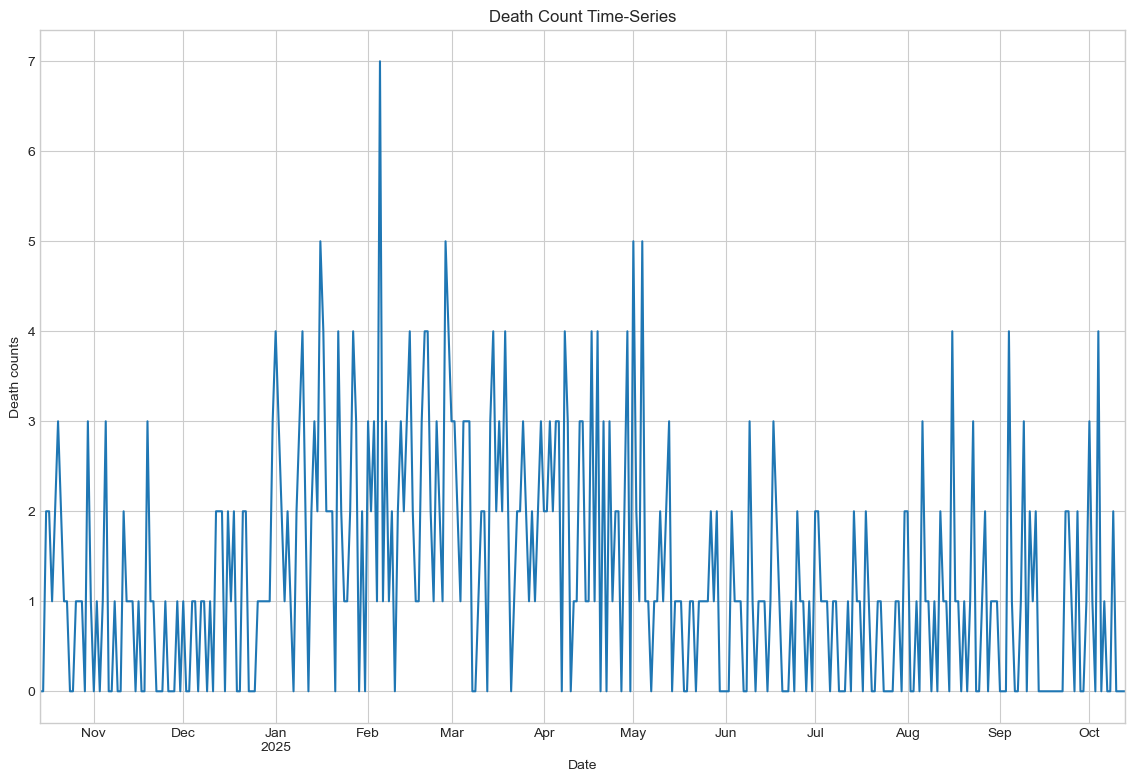

In [179]:
fig = plt.figure(figsize=(14,9))
ts.plot()
plt.xlabel("Date")
plt.ylabel('Death counts')
plt.title("Death Count Time-Series")
plt.show()


### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
- Visualize both resampled series 

In [180]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)
m_end = df_recent.set_index('date_of_interest').sort_index().resample('M')['death_count'].sum()
# Yearly totals can be derived from the month-end series (or resample directly)
y_sum = m_end.resample('Y').sum()

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_85878/4074351120.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_end = df_recent.set_index('date_of_interest').sort_index().resample('M')['death_count'].sum()
/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_85878/4074351120.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y_sum = m_end.resample('Y').sum()


In [185]:
m_end

date_of_interest
2024-10-31    21
2024-11-30    19
2024-12-31    29
2025-01-31    65
2025-02-28    70
2025-03-31    62
2025-04-30    58
2025-05-31    39
2025-06-30    25
2025-07-31    23
2025-08-31    30
2025-09-30    22
2025-10-31    11
Freq: ME, Name: death_count, dtype: int64

In [186]:
y_sum

date_of_interest
2024-12-31     69
2025-12-31    405
Freq: YE-DEC, Name: death_count, dtype: int64

### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

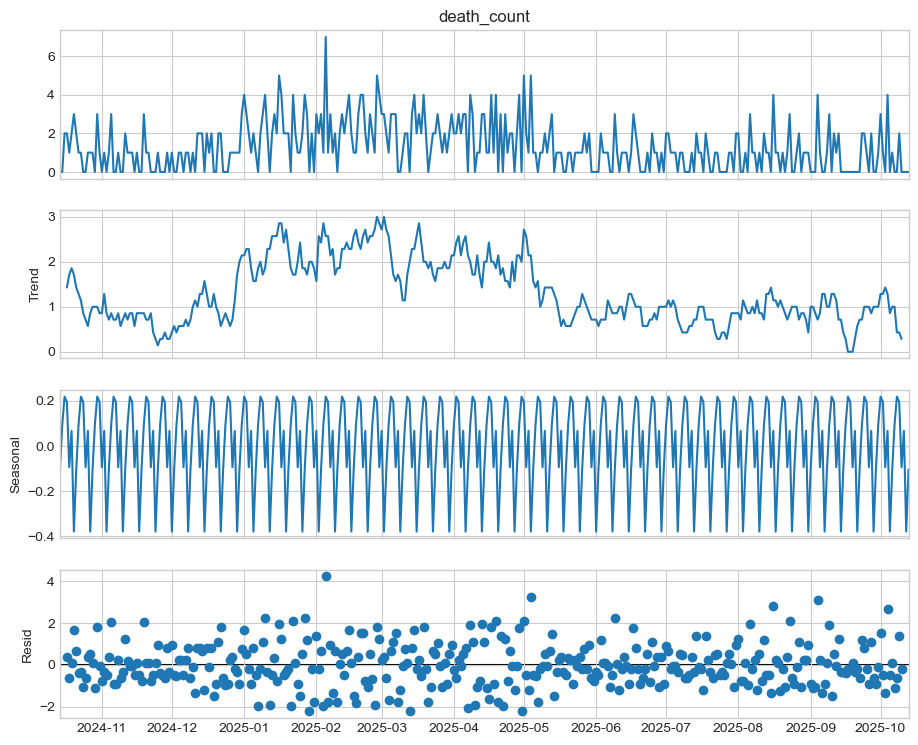

In [182]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
decomp = seasonal_decompose(ts, model='additive', period=7,)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

In [183]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
from statsmodels.tsa.stattools import adfuller

print('--- ADF Test on Original Data ---')
adf_test = adfuller(ts)
print(f'ADF Statistic: {adf_test[0]:.2f}')
print(f'p-value: {adf_test[1]:.2f}')

# P-value is high, let's fix it by making it stationary (subtracting the previous value)
ts_diff = ts.diff().dropna() # Drop the first NaN value

print('\n--- ADF Test on Differenced Data ---')
adf_test_diff = adfuller(ts_diff)
print(f'ADF Statistic: {adf_test_diff[0]:.2f}')
print(f'p-value: {adf_test_diff[1]:.2f}') # Now the p-value is less than 5%

--- ADF Test on Original Data ---
ADF Statistic: -1.64
p-value: 0.46

--- ADF Test on Differenced Data ---
ADF Statistic: -9.33
p-value: 0.00


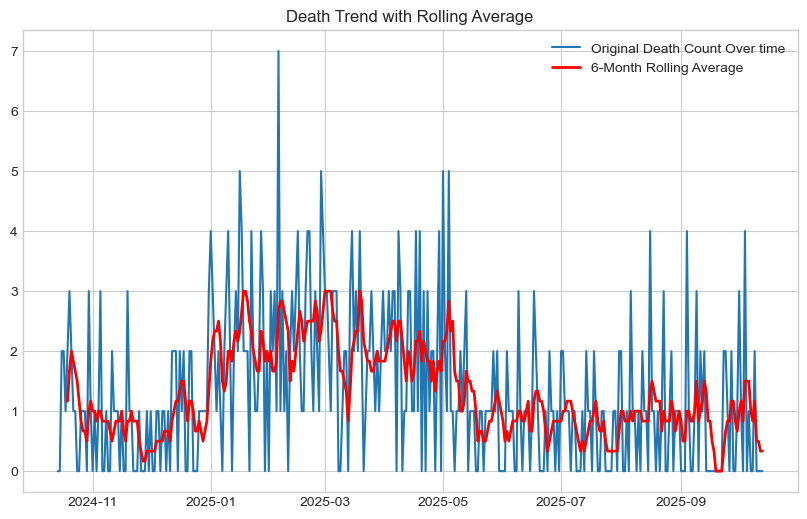

In [184]:
# Calculate a 6-month moving average to smooth the data
ts_ma = ts.rolling(window=6).mean()

plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original Death Count Over time', alpha=1)
plt.plot(ts_ma, label='6-Month Rolling Average', color='red', linewidth=2)
plt.legend()
plt.title('Death Trend with Rolling Average')
plt.show()

## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).
- Over the 12‑month window the death_count series shows a generally flat to declining trend with a clear weekly seasonality and also a small, sharp spikes indicating occasional volatility.
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?
- The raw series had first a high p-value (the data was not stationary), but after transformation by substracting the previous value, it produded a p-value less than 5%. This is an important process in modeling because it helps remove and make the mean and variance stay the same. Also, makes the data more reliable and easier to forescast.
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?
- Month-end totals, and post-holiday season show some additional peaks. But, after resampling month‑end  (m_end), the pattern becomes clear, we can obsserve a spike in the death count for 2025 compare to the previous year.